# __Advanced Machine Learning - Exercise Sheet 1__
## _Elias Eulig, Karsten Roth, Benedict Kerres_

## 1.1 Loading the Dataset
---

In [1]:
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()

data   = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(digits.keys())
print(data.dtype)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64


In [2]:
#Example Plot/Sanity check
import matplotlib.pyplot as plt
plt.imshow(images[10,:],cmap='gray')
plt.title(target[10])
plt.axis('off')
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
#Creating feature matrix subset
X = data[(target==3) | (target==8),:]
X = np.c_[X,np.ones(X.shape[0])]

y = target[(target==3) | (target==8)]
y[y==3] = 1
y[y==8] = -1


## 1.1 Classification with sklearn
---

In [4]:
### Start Regression
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3,
random_state = 0)

c_s = np.logspace(-5.0,1.0, num=10)
results = []
for c in c_s:
    model = LogisticRegression(C=c)
    model.fit(X_train,y_train);
    y_test_pred = model.predict(X_test)
    results.append(float(np.sum(y_test_pred==y_test))/len(y_test))
    
print('\n'.join('[{}] {}'.format(i+1,res) for i,res in enumerate(results)))
c = c_s[np.argmax(results)]
print('==> C to use:%.4f'%(c))

[1] 0.9814814814814815
[2] 0.9814814814814815
[3] 0.9814814814814815
[4] 0.9814814814814815
[5] 1.0
[6] 1.0
[7] 1.0
[8] 1.0
[9] 1.0
[10] 1.0
==> C to use:0.0046


/Users/eliaseulig/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1.2 Optimization Methods
---

In [5]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))

def gradient(beta, lam, X, y):
    z  = y.dot(X).dot(beta)
    v1 = sigmoid(z)*(y.dot(X)*np.exp(z))
    return (beta/lam) + (1/X.shape[0])*v1

def predict(beta, X):
    return 1-np.round(sigmoid(X.dot(beta.T)))*2

def zero_one_loss(y_prediction, y_truth):
    return np.sum(y_prediction!=y_truth)

In [6]:
### Learning rate scheduler
class lr_scheduler():
    def __init__(self, lr=None, gamma=None):
        if lr is not None:
            self.lr = lr
            self.lr_init = lr
        else:
            self.lr = 1e-2
            self.lr_init = 1e-2
        if gamma is not None:
            self.gamma = gamma
        else:
            self.gamma = 0.0001

        self.it    = 0

    def update(self):
        self.it += 1
        self.lr = self.lr_init/(1+self.gamma*self.it)

    def give(self):
        return self.lr

In [7]:
rng = np.random.RandomState(1)

#Gradient Descent
def gradient_descent_update(beta, lam, tau, steps, X, y):
    coll = []    
    for _ in range(steps):
        beta = beta-tau*gradient(beta, lam, X, y)
        y_prediction = predict(beta, X)
        coll.append(zero_one_loss(y_prediction, y))
    
    plt.plot(coll)
    return beta


#Stochastic Gradient Descent
def stochastic_gradient_descent_update(beta, lam, tau, steps, X, y, gamma=0.0001):
    lr_s = lr_scheduler(lr=tau)
    lr_s.gamma = gamma
    
    coll = []
    for _ in range(steps):
        idx  = rng.randint(len(X),size=1)
        beta = beta-tau*gradient(beta, lam, X[idx,:],y[idx])
        lr_s.update()
        tau = lr_s.give()
        y_prediction = predict(beta, X)
        coll.append(zero_one_loss(y_prediction, y))
    
    plt.plot(coll)
    return beta



#Stochastic MiniBatch Gradient Descent
def stochastic_minibatch_descent_update(beta, lam, tau, steps, X, y, mbs=12, gamma=0.0001):
    lr_s = lr_scheduler(lr=tau)
    lr_s.gamma = gamma
    
    coll = []
    for _ in range(steps):
        idx  = rng.randint(len(X), size=mbs)
        beta = beta-tau*gradient(beta, lam, X[idx,:], y[idx])
        lr_s.update()
        tau = lr_s.give()
        y_prediction = predict(beta, X)
        coll.append(zero_one_loss(y_prediction, y))
    
    plt.plot(coll)
        
    return beta



#Stochastic Gradient Descent with Momentum
def stochastic_gradient_descent_momentum_update(beta, lam, tau, steps, X, y, mu=0.9, mom_coll=None, gamma=0.0001):
    lr_s = lr_scheduler(lr=tau)
    lr_s.gamma = gamma
    coll = []

    if mom_coll is None:
        mom_coll = 0

    for _ in range(steps):
        idx = rng.randint(len(X),size=1)
        mom_coll = (1-mu)*mom_coll +\
                   mu*gradient(beta, lam, X[idx,:], y[idx])
        beta     = beta-tau*mom_coll
        lr_s.update()
        tau = lr_s.give()

        y_prediction = predict(beta, X)
        coll.append(zero_one_loss(y_prediction, y))
    
    plt.plot(coll)
    
    return beta


#ADAM
def adam(beta, lam, tau, steps, X, y, mu_one=0.9, mu_two=0.999, epsilon=1e-8, mom_coll=None, mom_coll_snd=None):    
    coll = []
    
    if mom_coll is None:
        mom_coll = 0
    if mom_coll_snd is None:
        mom_coll_snd = 0
        
    for _ in range(steps):
        idx       = rng.randint(len(X),size=1)
        mom_coll  = mu_one*mom_coll+\
                    (1-mu_one)*gradient(beta, lam, X[idx,:],y[idx])
        mom_coll_snd = mu_two*mom_coll_snd+\
                       (1-mu_two)*gradient(beta, lam, X[idx,:], y[idx])**2
        beta      = beta-(tau/(np.sqrt(mom_coll_snd)+epsilon))*mom_coll

        y_prediction = predict(beta, X)
        coll.append(zero_one_loss(y_prediction, y))
    
    plt.plot(coll)
    return beta

#Stochastic Average Gradient Descent
def SAG(beta, lam, tau, steps, X, y, gamma=0.0001):
    lr_s = lr_scheduler(lr=tau)
    lr_s.gamma = gamma
    #initialization
    coll = []
    g_stored=np.zeros(X.shape)
    for i in range(len(g_stored)):
        g_stored[i,:]=-y[i]*X[i,:].T*sigmoid(-y[i]*X[i,:].dot(beta))
    g_t = (1/len(g_stored))*sum(g_stored,0)

    for _ in range(steps):
        idx       = rng.randint(len(X),size=1)[0]
        g_i_t = -y[idx]*X[idx,:]*sigmoid(-y[idx]*X[idx,:].dot(beta))
        g_t = g_t + (1/len(g_stored))*(g_i_t-g_stored[idx,:])
        g_stored[idx,:] = g_i_t
        beta=beta*(1-(tau/lam))-tau*g_t
        
        lr_s.update()
        tau = lr_s.give()
        
        y_prediction = predict(beta, X)
        coll.append(zero_one_loss(y_prediction, y))
    plt.plot(coll)
    return beta

#Dual Coordinate Ascent
def DCA(lam, tau, steps, X, y, epsilon):
    coll= []
    #initialization
    alpha = np.random.rand(len(X),1)
    betas = np.zeros(X.shape)
    for i in range(len(betas)):
        betas[i,:]=alpha[i]*y[i]*X[i,:]
    beta = (lam/len(X))*np.sum(betas,0)
    
    for _ in range(steps):
        f_1 = y[i]*X[i,:].dot(beta)+np.log(alpha[i]/(1-alpha[i]))
        f_2 = (lam/len(X))*X[i,:].dot(X[i,:])+(1/(alpha[i]*(1-alpha[i])))

        oldalpha_i = alpha[i]
        alpha[i] = np.clip(alpha[i]-f_1/f_2,epsilon,1-epsilon)
        beta = beta + (lam/len(X))*y[i]*X[i,:]*(alpha[i]-oldalpha_i)
        
        y_prediction = predict(beta, X)
        coll.append(zero_one_loss(y_prediction, y))
    plt.plot(coll)
    return beta

#Newton Raphson
def Newton_Raphson(beta, lam, steps, X, y):
    coll= []
    for _ in range(steps):
        z_t = X.dot(beta)
        y_tilde_t = y/sigmoid(y.dot(z_t))
        W = (lam/len(X))*np.expand_dims(sigmoid(z_t),1).dot(np.expand_dims(sigmoid(-z_t),0))
        beta = np.linalg.inv(np.identity(65)+X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(z_t+y_tilde_t)

        y_prediction = predict(beta, X)
        coll.append(zero_one_loss(y_prediction, y))
    plt.plot(coll)
    return beta      

In [8]:
### Start Training
SGD_feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'tau':  0.000003,
                 'steps':10000,
                 'X':    X,
                 'y':    y
                }

SGDmb_feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'tau':  0.00003,
                 'steps':1000,
                 'X':    X,
                 'y':    y, 
                 'mbs':  24 
                }

GD_feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'tau':  0.0001,
                 'steps':5,
                 'X':    X,
                 'y':    y
                }

SGDmo_feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'tau':  0.000001,
                 'steps':10000,
                 'X':    X,
                 'y':    y, 
                 'mu':   0.9
                }

ADAM_feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'tau':  0.0001,
                 'steps':10000,
                 'X':    X,
                 'y':    y
                }
SAG_feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'tau':  0.000001,
                 'steps':10000,
                 'X':    X,
                 'y':    y
                }
DCA_feed_dict = {'lam':  c,
                 'tau': 0.00001,
                 'steps':10000,
                 'X':    X,
                 'y':    y,
                 'epsilon': 0,
                }
Newton_Raphson_feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'steps':100,
                 'X':    X,
                 'y':    y
                }

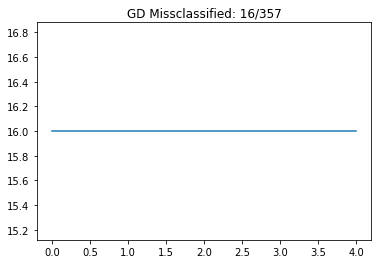

In [9]:
### Examine Gradient Descent
optim_method = gradient_descent_update
beta  = optim_method(**GD_feed_dict)
y_prediction = predict(beta, X)
n_missclass  = zero_one_loss(y_prediction, y)
plt.title('GD Missclassified: {}/{}'.format(n_missclass, len(y)))
plt.show()

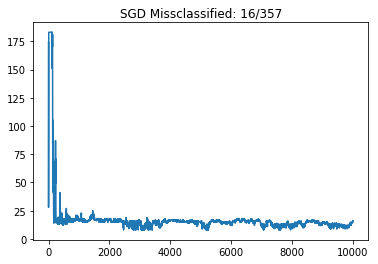

In [10]:
### Examine SGD
optim_method = stochastic_gradient_descent_update
beta  = optim_method(**SGD_feed_dict)
y_prediction = predict(beta, X)
n_missclass  = zero_one_loss(y_prediction, y)
plt.title('SGD Missclassified: {}/{}'.format(n_missclass, len(y)))
plt.show()

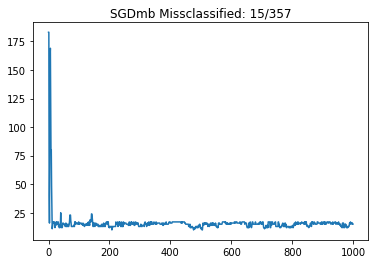

In [11]:
### Examine MBS SGD
optim_method = stochastic_minibatch_descent_update
beta  = optim_method(**SGDmb_feed_dict)
y_prediction = predict(beta, X)
n_missclass  = zero_one_loss(y_prediction, y)
plt.title('SGDmb Missclassified: {}/{}'.format(n_missclass, len(y)))
plt.show()

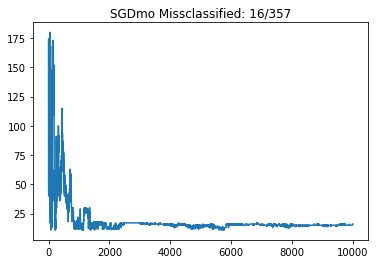

In [12]:
### Examine SGD with momentum
optim_method = stochastic_gradient_descent_momentum_update
beta  = optim_method(**SGDmo_feed_dict)
y_prediction = predict(beta, X)
n_missclass  = zero_one_loss(y_prediction, y)
plt.title('SGDmo Missclassified: {}/{}'.format(n_missclass, len(y)))
plt.show()

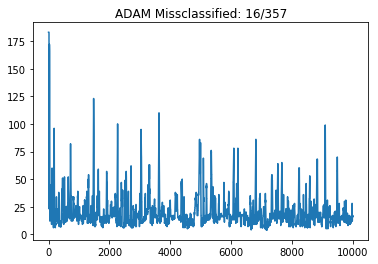

In [13]:
### Examine Adam
optim_method = adam
beta  = optim_method(**ADAM_feed_dict)
y_prediction = predict(beta, X)
n_missclass  = zero_one_loss(y_prediction, y)
plt.title('ADAM Missclassified: {}/{}'.format(n_missclass, len(y)))
plt.show()

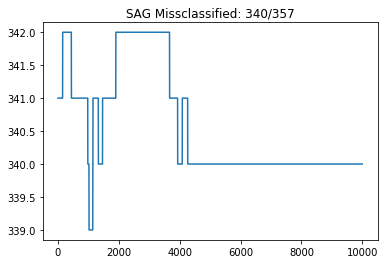

In [14]:
### Examine stochastic average gradient
optim_method = SAG
beta  = optim_method(**SAG_feed_dict)
y_prediction = predict(beta, X)
n_missclass  = zero_one_loss(y_prediction, y)
plt.title('SAG Missclassified: {}/{}'.format(n_missclass, len(y)))
plt.show()

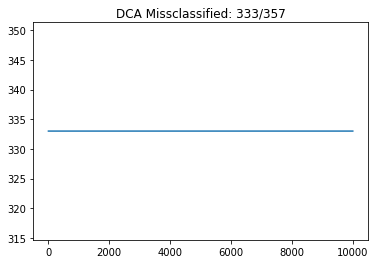

In [15]:
### Examine dual coordinate ascent
optim_method = DCA
beta  = optim_method(**DCA_feed_dict)
y_prediction = predict(beta, X)
n_missclass  = zero_one_loss(y_prediction, y)
plt.title('DCA Missclassified: {}/{}'.format(n_missclass, len(y)))
plt.show()

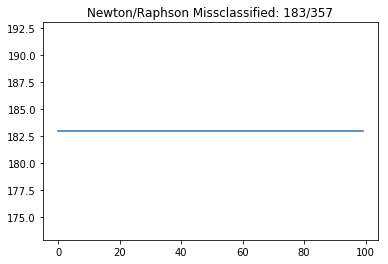

In [16]:
### Examine Newton/Raphson
optim_method = Newton_Raphson
beta  = optim_method(**Newton_Raphson_feed_dict)
y_prediction = predict(beta, X)
n_missclass  = zero_one_loss(y_prediction, y)
plt.title('Newton/Raphson Missclassified: {}/{}'.format(n_missclass, len(y)))
plt.show()

## 1.3 Comparison

## Investigate the hyperparameters

In [17]:
from sklearn import cross_validation

taus = [0.001,0.01,0.1]
mus = [0.1,0.2,0.5]
gammas = [0.0001, 0.001, 0.01]
kf = cross_validation.KFold(y.shape[0], n_folds=10)
#--------------- GD
params = taus
param_error = []

for p in params:
    tot_error = []
    for train_index , validation_index in kf:
        X_train , X_validation = X[train_index], X[validation_index]
        y_train , y_validation = y[train_index], y[validation_index]
        feed_dict = {'beta': np.zeros(X.shape[-1]),
             'lam':  c,
             'tau':  p,
             'steps':10,
             'X':    X_train,
             'y':    y_train
            }
        optim_method = gradient_descent_update
        beta  = optim_method(**feed_dict)
        n_missclass  = zero_one_loss(predict(beta, X_validation), y_validation)
        tot_error.append(n_missclass)
    param_error.append(sum(tot_error))   
plt.close()
best_params = params[np.argmin(np.array(param_error))]

print('gradient descent | Best parameter set: tau={}'.format(best_params))
GD_bestfeed_dict = {'beta': np.zeros(X.shape[-1]),
                     'lam':  c,
                     'tau':  best_params,
                     'steps':10,
                     'X':    X,
                     'y':    y
                    }

#--------------- SG
params = [(t,g) for t in taus for g in gammas]
param_error = []
for p in params:
    tot_error = []
    for train_index , validation_index in kf:
        X_train , X_validation = X[train_index], X[validation_index]
        y_train , y_validation = y[train_index], y[validation_index]
        feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'tau':  p[0],
                 'steps':150,
                 'X':    X_train,
                 'y':    y_train,
                 'gamma':p[1]
            }
        optim_method = stochastic_gradient_descent_update
        beta  = optim_method(**feed_dict)
        n_missclass  = zero_one_loss(predict(beta, X_validation), y_validation)
        tot_error.append(n_missclass)
    param_error.append(sum(tot_error))   
plt.close()
best_params = params[np.argmin(np.array(param_error))]
print('SG (stochastic gradient) | Best parameter set: tau={}, gamma={}'.format(best_params[0], best_params[1]))
SGD_bestfeed_dict = {'beta': np.zeros(X.shape[-1]),
                     'lam':  c,
                     'tau':  best_params[0],
                     'steps':150,
                     'X':    X,
                     'y':    y,
                     'gamma':best_params[1]
                }

#--------------- SGmb
params = [(t,g) for t in taus for g in gammas]
param_error = []
for p in params:
    tot_error = []
    for train_index , validation_index in kf:
        X_train , X_validation = X[train_index], X[validation_index]
        y_train , y_validation = y[train_index], y[validation_index]
        feed_dict = {'beta': np.zeros(X.shape[-1]),
                         'lam':  c,
                         'tau':  p[0],
                         'steps':150,
                         'X':    X_train,
                         'y':    y_train, 
                         'mbs':  24,
                         'gamma': p[1]
                    }
        optim_method = stochastic_minibatch_descent_update
        beta  = optim_method(**feed_dict)
        n_missclass  = zero_one_loss(predict(beta, X_validation), y_validation)
        tot_error.append(n_missclass)
    param_error.append(sum(tot_error))   
plt.close()
best_params = params[np.argmin(np.array(param_error))]
print('SG minibatch | Best parameter set: tau={}, gamma={}'.format(best_params[0], best_params[1]))
SGDmb_bestfeed_dict = {'beta': np.zeros(X.shape[-1]),
                     'lam':  c,
                     'tau':  best_params[0],
                     'steps':150,
                     'X':    X,
                     'y':    y, 
                     'mbs':  24,
                     'gamma': best_params[1]
                }



#--------------- SGmom
params = [(t,g,m) for t in taus for g in gammas for m in mus]
param_error = []
for p in params:
    tot_error = []
    for train_index , validation_index in kf:
        X_train , X_validation = X[train_index], X[validation_index]
        y_train , y_validation = y[train_index], y[validation_index]
        feed_dict = {'beta': np.zeros(X.shape[-1]),
                         'lam':  c,
                         'tau':  p[0],
                         'steps':150,
                         'X':    X_train,
                         'y':    y_train, 
                         'mu':   p[2],
                         'gamma': p[1]
                    }
        optim_method = stochastic_gradient_descent_momentum_update
        beta  = optim_method(**feed_dict)
        n_missclass  = zero_one_loss(predict(beta, X_validation), y_validation)
        tot_error.append(n_missclass)
    param_error.append(sum(tot_error))   
plt.close()
best_params = params[np.argmin(np.array(param_error))]
print('SG momentum | Best parameter set: tau={}, gamma={}, mom={}'.format(best_params[0], best_params[1],best_params[2]))
SGDmo_bestfeed_dict = {'beta': np.zeros(X.shape[-1]),
                     'lam':  c,
                     'tau':  best_params[0],
                     'steps':150,
                     'X':    X,
                     'y':    y, 
                     'mu':   best_params[2],
                     'gamma': best_params[1]
                }
    
#--------------- ADAM
params = [(t,m,m) for t in taus for m in mus for m in mus]        
param_error = []
for p in params:
    tot_error = []
    for train_index , validation_index in kf:
        X_train , X_validation = X[train_index], X[validation_index]
        y_train , y_validation = y[train_index], y[validation_index]

        feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'tau':  p[0],
                 'steps':150,
                 'X':    X_train,
                 'y':    y_train,
                 'mu_one': p[1],
                 'mu_two': p[2]
            }
        optim_method = adam
        beta  = optim_method(**feed_dict)
        n_missclass  = zero_one_loss(predict(beta, X_validation), y_validation)
        tot_error.append(n_missclass)
    param_error.append(sum(tot_error))   
plt.close()
best_params = params[np.argmin(np.array(param_error))]
print('ADAM | Best parameter set: tau={}, mu_one={}, mu_two={}'.format(best_params[0], best_params[1], best_params[2]))
ADAM_bestfeed_dict = {'beta': np.zeros(X.shape[-1]),
                     'lam':  c,
                     'tau':  best_params[0],
                     'steps':150,
                     'X':    X,
                     'y':    y, 
                     'mu_one': best_params[1],
                     'mu_two': best_params[2]
                }

#--------------- SAG
params = [(t,g) for t in taus for g in gammas]        
param_error = []
for p in params:
    tot_error = []
    for train_index , validation_index in kf:
        X_train , X_validation = X[train_index], X[validation_index]
        y_train , y_validation = y[train_index], y[validation_index]

        feed_dict = {'beta': np.zeros(X.shape[-1]),
                 'lam':  c,
                 'tau':  p[0],
                 'steps':150,
                 'X':    X_train,
                 'y':    y_train,
                 'gamma': p[1]
            }
        optim_method = SAG
        beta  = optim_method(**feed_dict)
        n_missclass  = zero_one_loss(predict(beta, X_validation), y_validation)
        tot_error.append(n_missclass)
    param_error.append(sum(tot_error))   
plt.close()
best_params = params[np.argmin(np.array(param_error))]
print('SAG | Best parameter set: tau={}, gamma={}'.format(best_params[0], best_params[1]))
SAG_bestfeed_dict = {'beta': np.zeros(X.shape[-1]),
                     'lam':  c,
                     'tau':  best_params[0],
                     'steps':150,
                     'X':    X,
                     'y':    y,
                     'gamma': best_params[1]
                }

#--------------- DCA
DCA_bestfeed_dict = DCA_feed_dict
#--------------- Newton_Raphson
Newton_Raphson_bestfeed_dict = Newton_Raphson_feed_dict

gradient descent | Best parameter set: tau=0.001
SG (stochastic gradient) | Best parameter set: tau=0.001, gamma=0.0001
SG minibatch | Best parameter set: tau=0.001, gamma=0.01
SG momentum | Best parameter set: tau=0.001, gamma=0.01, mom=0.1
ADAM | Best parameter set: tau=0.1, mu_one=0.5, mu_two=0.5
SAG | Best parameter set: tau=0.1, gamma=0.001


## Investigate the speed

In [18]:
###Investigate the Speed of the algorithms
N=len(X_train)
D=65
#Setup training and test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3,random_state = 0)


def investigate_optimizer_speed(optimizer, feed_dict, complexity, X_train, X_test, y_train, y_test, num_iterations = np.array([5,10,15,25,50,100,1000])):
    train_error=[]
    test_error=[]
    feed_dict['X'] = X_train
    feed_dict['y'] = y_train
    for steps in num_iterations:
        feed_dict['steps'] = steps

        optim_method = optimizer
        beta  = optim_method(**feed_dict)
        train_error.append(zero_one_loss(predict(beta, X_train), y_train)*100/len(y_train))
        test_error.append(zero_one_loss(predict(beta, X_test), y_test)*100/len(y_test))
    plt.close()
    plt.semilogy(num_iterations*complexity, train_error, label='train error')
    plt.semilogy(num_iterations*complexity, test_error, label='test error')
    plt.xlabel('Runtime')
    plt.ylabel('Misclassification error (%)')
    plt.legend()

##### gradient descent

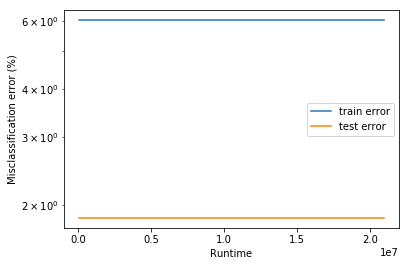

In [19]:
investigate_optimizer_speed(gradient_descent_update,GD_bestfeed_dict,N*D, X_train, X_test, y_train, y_test)

##### SG (stochastic gradient)

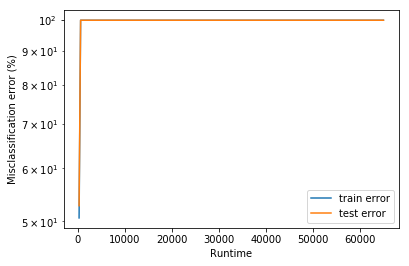

In [20]:
investigate_optimizer_speed(stochastic_gradient_descent_update,SGD_bestfeed_dict,D, X_train, X_test, y_train, y_test)

##### SG minibatch

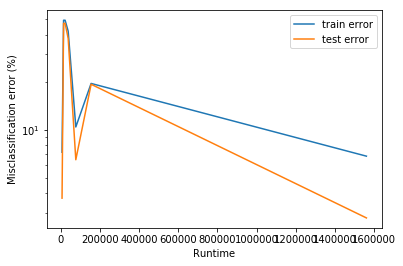

In [21]:
investigate_optimizer_speed(stochastic_minibatch_descent_update,SGDmb_bestfeed_dict,24*D, X_train, X_test, y_train, y_test)

##### SG momentum

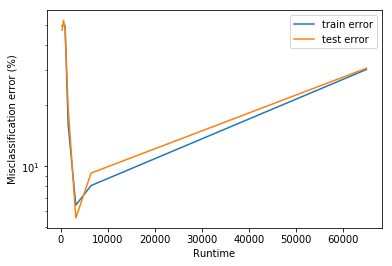

In [22]:
investigate_optimizer_speed(stochastic_gradient_descent_momentum_update,SGDmo_bestfeed_dict,D, X_train, X_test, y_train, y_test)

##### ADAM

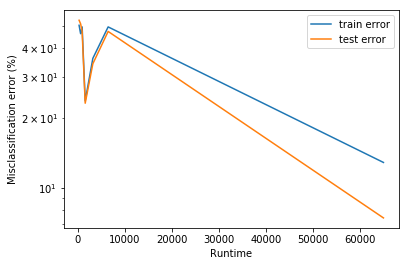

In [23]:
investigate_optimizer_speed(adam,ADAM_bestfeed_dict,D, X_train, X_test, y_train, y_test)

##### stochastic average gradient

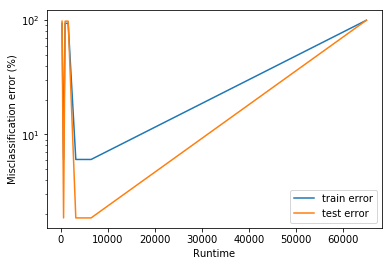

In [24]:
investigate_optimizer_speed(SAG,SAG_bestfeed_dict,D, X_train, X_test, y_train, y_test)

##### dual coordinate ascent

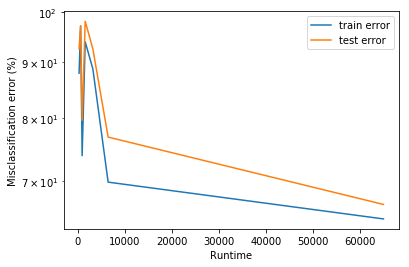

In [25]:
investigate_optimizer_speed(DCA,DCA_bestfeed_dict,D, X_train, X_test, y_train, y_test)

##### Newton/Raphson

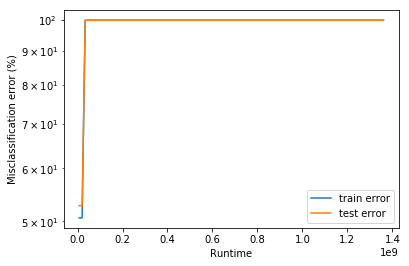

In [26]:
investigate_optimizer_speed(Newton_Raphson,Newton_Raphson_bestfeed_dict,N*D**2, X_train, X_test, y_train, y_test)

Unfortunately the learning rates for which we should examin the behaviour for our optimization mehtods were by far too high for most of the methods (e.g. SGD, SDGmom, ADAM,...) and thus the algorithms are diverging even with the best learning rates chosen. We are sorry if we misunderstood something.